# 18460 Project

In [60]:
%load_ext autoreload
%autoreload 2

from tasks import *
import numpy as np
from server import Server
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we initialize the task for a given configuration

In [61]:
#task = lrt.LinearRegressionTask(lrt.solo_config) # Linear regression
#task = ct.CircleTask(ct.solo_config) # Circle
task = lgrt.LogisticRegressionTask() # Logistic regression with mushrooms

Intializing task LogisticRegressionTask with config Config(clients=[<Computation.HIGH: 1>], lr=0.01, nlr=0.01)


Seeing the data

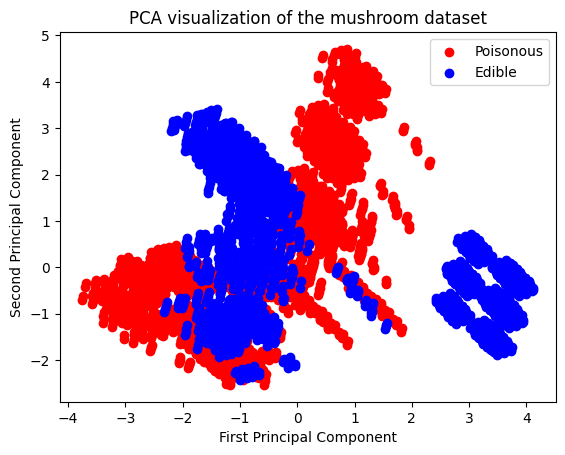

In [3]:
task.visualize()

Solve iteratively using federated learning

In [62]:
# Create server and initialize clients, before iteratively updating the consensus variables
server = Server(task)
server.connect_clients() # create clients with problem description including a partition of the dataset

start_time = time.perf_counter()
problem = task.get_problem()

k = 0
accuracys = []
last_cost = float('infinity')
while k < problem.max_iter and server.delta > problem.tol:
    consensus = server.consensus.flatten()
    
    current_cost = problem.loss(consensus, task.dataset, problem.hyper_parameters)
    
    if k % 500 == 0:
        print(f'''
        Iteration {k}: {consensus}
        Cost: {current_cost}

        ''')
    
    # perform new iteration
    server.run_iteration(k+1)
    
    if np.linalg.norm(current_cost - last_cost) < problem.ctol:
        print(f"Condition reached: change in cost is {np.linalg.norm(current_cost - last_cost)} "
              f"which is smaller than {problem.ctol}")
        last_cost = current_cost
        break
        
    last_cost = current_cost

    solution = server.consensus.flatten()
    prediction = task.get_prediction(solution)
    accuracy = task.get_accuracy(prediction)
    accuracys.append(accuracy)
    
    k = k + 1
    
end_time = time.perf_counter()
if k >= problem.max_iter and server.delta > problem.tol:
    raise Exception("Did not converge")
    
if server.delta <= problem.tol:
    print(f"Condition reached: change in solution is {server.delta} "
          f"which is smaller than {problem.tol}")

print("")
print(f"Solution: {solution}")
print(f"Associated cost: {last_cost}")
print(f"Achieved in {k} iterations")
print(f"Elasped time: {end_time - start_time}")


        Iteration 0: [-1.69344806 -0.76224513  0.50641708 -0.0899555   0.57634274  0.91699924
  0.96810929  0.62437919  0.38258642  0.27490578 -1.6599372   0.26705086
  0.27262374 -1.50129017 -1.09929324 -1.33981219 -0.69572217  1.51965428
  0.06079374 -0.53967767 -0.25626155  0.81533756  0.460848  ]
        Cost: 12876.783407287006

        

        Iteration 500: [-0.18852201  0.22125854  0.0502047  -0.89269858 -0.30792398 -0.14181184
 -1.10712671  1.89289248 -0.24257515 -0.07204379 -0.83491468 -0.8566091
 -0.33398527 -0.35901229 -0.21236647 -1.33981219  0.83237168  0.18597067
  0.48685353 -0.85662428 -0.27206292  0.21667605 -0.07113161]
        Cost: 1669.368549398472

        

        Iteration 1000: [-0.07796258  0.38586578 -0.01495942 -0.83547214 -0.56973272 -0.40564047
 -1.45775083  2.20215985 -0.30734584 -0.01980458 -0.85761021 -1.16194504
 -0.36065118 -0.25776558 -0.13291566 -1.33981219  1.26173582  0.2806942
  0.58138164 -0.79219345 -0.28468102  0.10908077 -0.11362899]
   


        Iteration 12000: [-0.02596992  0.56150865 -0.1508838  -0.39044329 -1.52404836 -2.09431492
 -3.57389446  4.59813577 -0.49150188  0.52857249 -2.47226286 -3.97009238
 -0.03454532 -0.29348668 -0.10278991 -1.33981219  4.58420943  0.8351595
  2.55738937 -0.75289291 -0.91542439  0.03360882 -0.49453157]
        Cost: 1319.1302490992045

        

        Iteration 12500: [-0.02474087  0.5613801  -0.15370353 -0.3733576  -1.54425626 -2.13942568
 -3.63670489  4.66638405 -0.49507402  0.52565102 -2.54293176 -4.03827231
 -0.0244508  -0.29537247 -0.1029972  -1.33981219  4.67997341  0.83974904
  2.62566116 -0.74969988 -0.92933715  0.03457781 -0.51926921]
        Cost: 1318.6825680409188

        

        Iteration 13000: [-0.0235635   0.56103439 -0.1563546  -0.35632186 -1.56354409 -2.18282519
 -3.69823876  4.73301556 -0.49843631  0.52091013 -2.61414535 -4.10323081
 -0.01494836 -0.29726746 -0.10333665 -1.33981219  4.77338675  0.84333365
  2.69348581 -0.74617288 -0.94230775  0.03573509 -0.5449

## Visualization of the solution

In [ ]:
task.visualize_solution(solution)

In [ ]:
plt.plot(range(1, k+1), accuracys)
#plt.yscale("log")
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.show()